# Image generation using CLIP and VQGAN - implementation with tricks

Now it's time to take our implementation and add tricks to make output image better.

In [1]:
# Image transformations
from torchvision import transforms

# Pytorch modules
import torch
from torch import nn, optim
from torch.nn import functional as F

# Misc for progress bar, saving and didplay
import math
from tqdm.notebook import tqdm
from IPython import display
from PIL import ImageFile, Image

# All magic from basic notebook
from synth import *

In [2]:
device = get_device(use_gpu = True)

In [3]:
CLIP_MODEL_FILEPATH = "weights/ViT-B-32.pt"
VQGAN_CONFIG_FILEPATH = "weights/sflckr.yaml"
VQGAN_CHECKPOINT_FILEPATH = "weights/sflckr.ckpt"

model_clip, _ = load_clip(CLIP_MODEL_FILEPATH, device)
model_vqgan = load_vqgan(VQGAN_CHECKPOINT_FILEPATH, VQGAN_CONFIG_FILEPATH, device)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from weights/sflckr.ckpt


## Data agumentation

This will force model to consider more general picture of the image.

In [4]:
class Agumenter:
    def __init__(self, device, cutn=10, cut_size=224, cut_pow=1.):
        self.cut_pow = cut_pow
        self.cutn = cutn
        
        # Note: nn.Sequential is so we can backpropagate through.
        # Compose from torchvision is not differentiable.
        self.cut_size = cut_size
        self.augs = nn.Sequential(
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=30),
            transforms.RandomPerspective(0.2,p=0.4),
            transforms.ColorJitter(hue=0.01, saturation=0.01)
        ).to(device)

        self.norm = transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                                         (0.26862954, 0.26130258, 0.27577711)).to(device)
        
        self.resize = transforms.Resize(cut_size).to(device)

    def __call__(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(self.resize(cutout))
            
        batch = self.augs(torch.cat(cutouts, dim=0))
        return self.norm(batch)

We also need a different objective function. Now we have multiple images so we need to compute mean of cosine similarities between text encoding and encoding of each version of the input image.

In [5]:
class ObjectiveAgumentedImage:
    def __init__(self, prompt, agumenter, model_clip, device):
        t = clip.tokenize([prompt]).to(device)
        self.text_embedding = model_clip.encode_text(t).detach()
        self.model = model_clip
        self.agumenter = agumenter

    def __call__(self, img):
        img = self.agumenter(img)
        img_encoding = self.model.encode_image(img)
        return torch.cosine_similarity(img_encoding, self.text_embedding, -1).mean() * -1

agumenter = Agumenter(device)
objective = ObjectiveAgumentedImage("Mountain range under blue sky covered in snow", agumenter, model_clip, device)

In [6]:
z = initialize_z(256, 256, model_vqgan, device)
z.requires_grad_(True)
opt = optim.Adam([z], lr=1e-2)

epoch: 1999, loss: -0.395751953125


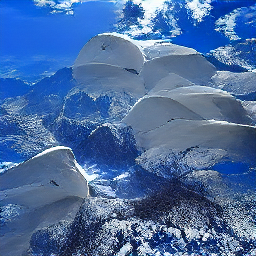

In [7]:
run(opt, z, objective, model_vqgan, model_clip, 2000)